In [1]:
import numpy as np
from coremdlr.datasets import WellLoader, FaciesDataset

Using TensorFlow backend.


In [2]:
fdset = FaciesDataset(["205-21b-3", "204-19-6","204-24a-6"],
                    test_wells=["204-20-6a"],
                    features=["image"])

fdset.load_or_generate_data()

Loading Well:  205-21b-3
Feature shapes:  [('depth', (3838,)), ('image', (3838, 32, 600, 3))]
Loading Well:  204-19-6
Feature shapes:  [('depth', (1888,)), ('image', (1888, 32, 600, 3))]
Loading Well:  204-24a-6
Feature shapes:  [('depth', (13007,)), ('image', (13007, 32, 600, 3))]
Loading Well:  204-20-6a
Feature shapes:  [('depth', (3873,)), ('image', (3873, 32, 600, 3))]


[3 0 0 ... 1 2 1]


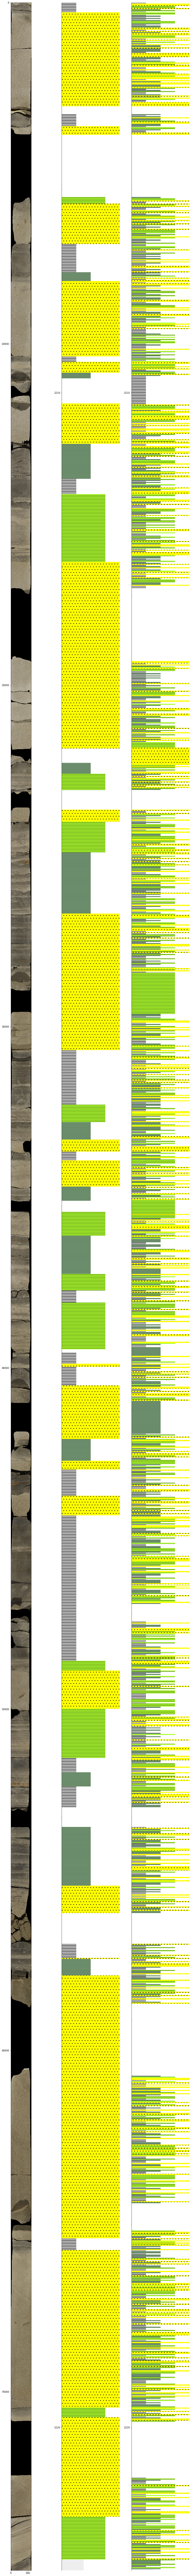

In [47]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

from coremdlr.utils.base_utils import smooth1D

import lasio
from coremdlr.datasets import strip_config
from striplog import Interval, Striplog

descrips = ['s', 'is', 'ih', 'sh']


def labels_to_striplog(labels, tops, bottoms, component_map=None):
    
    intervals = []
    current_label = labels[0]
    current_top, current_bottom = tops[0], bottoms[0]
    
    for i in range(1, labels.size):
        if labels[i] == current_label:
            current_bottom = bottoms[i]
        else:
            interval = Interval(top=current_top, base=current_bottom,
                                description = descrips[current_label],
                                components = [strip_config.facies[current_label]])
            intervals.append(interval)
            current_label = labels[i]
            current_top, current_bottom = tops[i], bottoms[i]
    
    interval = Interval(top=current_top, base=bottoms[-1],
                        description = 's',
                        components = strip_config.collapsed_facies[current_label])
    intervals.append(interval)
        
    return Striplog(intervals)


def _make_tick_objects(depths, precision, format_str, tolerance=0.01):
    '''Generate depth tics+locs at given precision.'''
    fmt_fn = lambda x: format_str.format(x)
    ticks = [fmt_fn(depths[0])]
    locs  = [0]
    rmndr = depths % precision
    for i in range(1, rmndr.size-1):
        neighborhood = [rmndr[i-1],rmndr[i],rmndr[i+1]]
        if np.argmin(neighborhood) == 1 and neighborhood[1] < tolerance:
            ticks.append(fmt_fn(depths[i]))
            locs.append(i)
    ticks.append(fmt_fn(depths[-1]))
    locs.append(rmndr.size)
    return ticks, locs
        
    

def plot_preds(dataset, well_name, figsize=(15,650), tick_precision=0.1, format_str='{:.2f}',
               ignore_features=[], seperate_logs=True, preds=None, strip_legend=strip_config.legend):
    """Plot data from a well in `dataset`, optionally with predictions.

    Parameters
    ----------
    dataset : coremdlr.datasets.FacieDataset instance
    well_name : str
        Name of well to plot. Must be present in `dataset`.
    fig_size : tuple(int), optional
        Size of returned matplotlib figure, default=(15,650).
    tick_precision : float, optional
        Precision of depth ticks on first axis.
    format_str : str, optional
        Format string to use for formatting tick labels.
    ignore_features : list(str), optional
        Names of any features present in dataset that should not be plotted.
    seperate_logs : bool, optional
        If plotting 'logs', whether to use seperate axis for each one.
    preds : np.array, optional
        Predictions plotted to the right of labels, if given. Must have same shape as well.y.
    """
    assert type(dataset) is FaciesDataset, 'dataset must be a FacieDataset instance.'
    if well_name in dataset.well_names:
        well = dataset.wells[dataset.well_names.index(well_name)]
    elif well_name in dataset.test_well_names:
        well = dataset.test_wells[dataset.test_well_names.index(well_name)]
    else:
        raise ValueError('Given `well_name`: {} not present in `dataset`'.format(well_name))

    ''' LATER FOR MORE FEATURES
    use_features = dataset.features.difference(set(ignore_features))
    nfeature_ax = len(use_features)
    if 'logs' in use_features and seperate_logs == True:
        nfeature_ax += len(well.which_logs) - 1
    if preds is not None:
        assert preds.shape == well.y.shape, 'Labels `well.y` and `preds` must have the same shape.'
    nlabel_ax = 1 if preds is None else 2
    '''
    
    if well.collapse_missing:
        labels = well.y + 2
        preds = well.y + 2
    
    fig, ax = plt.subplots(ncols=3, figsize=figsize)
    
    # image axis 
    #ticks, locs = _make_tick_objects(well.X['depth'], tick_precision, format_str)
    #ax[0].yaxis.set_major_locator(ticker.FixedLocator((locs)))
    #ax[0].yaxis.set_major_formatter(ticker.FixedFormatter((ticks)))

    
    min_depth, max_depth = well.tops[0], well.bottoms[-1]
    good_rows = np.logical_and(well._depth > min_depth, well._depth < max_depth)
    ax[0].imshow(well._image[good_rows,...])
    
    # labels axis
    labels_strip = labels_to_striplog(well.y, well.tops, well.bottoms)
    labels_strip.plot(legend=well.legend, ax=ax[1])
    
    # preds axis 
    print(preds)
    preds = np.argmax(preds, axis=0) if preds.ndim > 1 else preds
    assert preds.shape == well.y.shape, 'preds and labels shape must match'
    preds_strip = labels_to_striplog(preds, well.tops, well.bottoms)
    preds_strip.plot(legend=well.legend, ax=ax[2])
    
    return fig


fig = plot_preds(fdset, "204-19-6", figsize=(15,200), preds=np.random.randint(0, 4, size=fdset.wells[1].y.shape))
plt.show()
        

In [4]:
imgs_shape = fdset.wells[0].X['image'].shape
imgs_shape

(3838, 32, 600, 3)

In [5]:
np.reshape(fdset.wells[0].X['image'], (imgs_shape[0]*imgs_shape[1], imgs_shape[2], imgs_shape[3])).shape

(122816, 600, 3)

In [22]:
well = fdset.wells[1]
well.legend

Legend(Decor({'component': Component({'lithology': 'sandstone', 'train': 'y'}), '_colour': '#ffff00', 'hatch': '.', 'width': 4.0})
Decor({'component': Component({'lithology': 'clay-prone sandstone', 'train': 'y'}), '_colour': '#adff2f', 'hatch': '--', 'width': 3.0})
Decor({'component': Component({'lithology': 'sandy mudstone', 'train': 'y'}), '_colour': '#8fbc8f', 'hatch': '---', 'width': 2.0})
Decor({'component': Component({'lithology': 'mudstone', 'train': 'y'}), '_colour': '#a9a9a9', 'hatch': '-', 'width': 1.0}))

In [23]:
well.tops, well.bottoms

(array([2208.08206075, 2208.08743078, 2208.09280081, ..., 2220.68602114,
        2220.69139117, 2220.6967612 ]),
 array([2208.08743078, 2208.09280081, 2208.09817083, ..., 2220.69139117,
        2220.6967612 , 2220.70213123]))

In [33]:
well_strip = labels_to_striplog(well.y, well.tops, well.bottoms)
well_strip

Striplog(62 Intervals, start=2208.082060748448, stop=2220.702131230072)

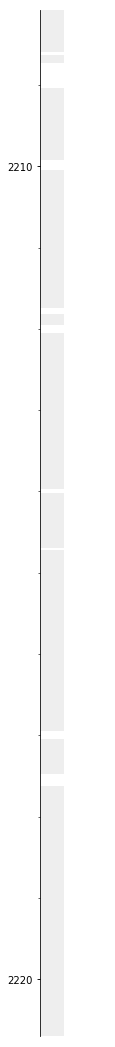

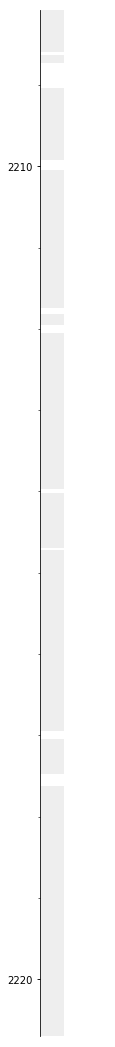

In [31]:
well_strip.plot(legend=strip_config.collapsed_legend, return_fig=True)

In [29]:
well_strip.thickest()

AttributeError: 'str' object has no attribute '_repr_html_'

Interval({'top': Position({'middle': 2217.7781506964257, 'units': 'm'}), 'base': Position({'middle': 2219.069810370868, 'units': 'm'}), 'description': 's', 'data': {}, 'components': ['lithology', 'train']})

In [34]:
print(well_strip)

{'top': Position({'middle': 2208.082060748448, 'units': 'm'}), 'base': Position({'middle': 2208.130391005202, 'units': 'm'}), 'description': 'sh', 'data': {}, 'components': ['lithology', 'train']}
{'top': Position({'middle': 2208.130391005202, 'units': 'm'}), 'base': Position({'middle': 2208.592213458634, 'units': 'm'}), 'description': 's', 'data': {}, 'components': ['lithology', 'train']}
{'top': Position({'middle': 2208.629803658332, 'units': 'm'}), 'base': Position({'middle': 2208.688873972143, 'units': 'm'}), 'description': 'sh', 'data': {}, 'components': ['lithology', 'train']}
{'top': Position({'middle': 2208.688873972143, 'units': 'm'}), 'base': Position({'middle': 2208.731834200369, 'units': 'm'}), 'description': 's', 'data': {}, 'components': ['lithology', 'train']}
{'top': Position({'middle': 2209.03773268489, 'units': 'm'}), 'base': Position({'middle': 2209.069931242663, 'units': 'm'}), 'description': 'is', 'data': {}, 'components': ['lithology', 'train']}
{'top': Position({

In [38]:
dir(well_strip[0])

['_Interval__parse_description',
 '__add__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_blend_descriptions',
 '_combine',
 '_combine_data',
 '_explode',
 '_overlaps',
 '_repr_html_',
 'any_overlaps',
 'base',
 'completely_contains',
 'components',
 'copy',
 'data',
 'description',
 'difference',
 'intersect',
 'invert',
 'is_contained_by',
 'kind',
 'max_thickness',
 'merge',
 'min_thickness',
 'order',
 'partially_overlaps',
 'primary',
 'relationship',
 'spans',
 'split_at',
 'summary',
 'thickness',
 'top',
 'touches',
 'union']

In [39]:
well_strip[0].components

['lithology', 'train']